# Analysis of Zenodo, Figshare and OSF data

With false-positive datasets removed

## Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yaml

# Update font size for graphics
plt.rcParams.update({'font.size': 20})

## Load data

In [2]:
df = pd.DataFrame()
for repository in ["zenodo", "figshare", "osf"]:
    datasets = pd.read_csv(f"../data/{repository}_datasets.clean.tsv", sep="\t")
    print(f"{repository}: found {datasets.shape[0]} datasets.")
    files = pd.read_csv(f"../data/{repository}_files.clean.tsv", sep="\t")
    print(f"{repository}: found {files.shape[0]} files.")
    tab = pd.merge(files, datasets, how="left", on=["dataset_id", "dataset_origin"], validate="many_to_one")
    print(f"{repository}: merged dataframe has {tab.shape[0]} entries.")
    df = pd.concat([df, tab], ignore_index=True)
print(f"Dimensions for final dataframe: {df.shape}")

zenodo: found 802 datasets.


/tmp/ipykernel_209433/1063939340.py:5: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  files = pd.read_csv(f"../data/{repository}_files.clean.tsv", sep="\t")


zenodo: found 120287 files.
zenodo: merged dataframe has 120287 entries.
figshare: found 807 datasets.
figshare: found 60572 files.
figshare: merged dataframe has 60572 entries.
osf: found 54 datasets.
osf: found 5510 files.
osf: merged dataframe has 5510 entries.
Dimensions for final dataframe: (186369, 18)


## Quick statistics

In [28]:
print(f"We have {df['dataset_id'].nunique()} datasets")
print(f"and {df.shape[0]} files.")

We have 1661 datasets
and 186369 files.


## Read query parameters

In [4]:
def read_md_file_types(filename):
    """Parse YAML file with MD file types.

    Parameters
    ----------
    filename : str
        Filename with MD file types.
    
    Returns
    -------
    file_types : dict
        Dictionary with type, engine, category and source
    """
    with open(filename, "r") as param_file:
        data_loaded = yaml.safe_load(param_file)
    file_types = data_loaded["file_types"]
    return file_types

In [5]:
dico_file_types = read_md_file_types("../params/file_types.yml")

ext_gromacs = []
ext_namd = []
ext_amber = []
ext_charmm = []

list_coordinate = []
list_trajectory = []
list_topology = []

for dico in dico_file_types:
    if dico["engine"] == "gromacs":
        ext_gromacs.append(dico["type"])
    elif dico["engine"] == "namd":
        ext_namd.append(dico["type"])
    elif dico["engine"] == "amber":
        ext_amber.append(dico["type"])
    elif dico["engine"] == "charmm":
        ext_charmm.append(dico["type"])

    if dico["category"] == "coordinate":
        list_coordinate.append(dico["type"])
    elif dico["category"] == "topology":
        list_topology.append(dico["type"])
    elif dico["category"] == "trajectory":
        list_trajectory.append(dico["type"])

ext_all = ext_gromacs + ext_namd + ext_amber + ext_charmm
        
# The filetype "top" is included in both Gromacs and Amber. 
# And, the filetype "prm" is included in Namd and Amber.
# But, to simplify the analyses, I consider that "top" is only a filetype of Gromacs and prm a filetype of Namd.

## Assign MD engine per file

In [6]:
def assign_md_engine(file_type):
    """Assign MD engine based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Name of MD engine.
    """
    if file_type in ext_gromacs:
        return "GROMACS"
    elif file_type in (ext_namd + ext_charmm):
        return "NAMD/CHARMM"
    elif file_type in ext_amber:
        return "AMBER"
    else:
        return "None"

df["engine_MD"] = df["file_type"].apply(assign_md_engine)
df["engine_MD"].value_counts()

None           110466
GROMACS         58936
NAMD/CHARMM      8801
AMBER            8166
Name: engine_MD, dtype: int64

## Assign file category

In [7]:
def assign_file_category(file_type):
    """Assign file category based on file type.
    
    Parameters
    ----------
    file_type : str
        File extension.
    
    Returns
    -------
    str
        Category.
    """
    if file_type in list_coordinate:
        return "coordinate"
    elif file_type in list_topology:
        return "topology"
    elif file_type in list_trajectory:
        return "trajectory"
    else:
        return "none"

df["category"] = df["file_type"].apply(assign_file_category)
df["category"].value_counts()

none          115801
trajectory     35826
topology       18368
coordinate     16374
Name: category, dtype: int64

## Extract year from date

In [8]:
df["year"] = df["date_creation"].apply(lambda x: int(x[:4]))

## Count number of files per dataset (without zip content)

In [9]:
(df
 .query("from_zip_file == False")
 .groupby("dataset_id")
 .agg({"file_md5": "size", "dataset_url":"first"})
 .rename(columns={"file_md5": "file_nb"})
 .describe()
)

,file_nb
count,1661.000000
mean,14.629741
std,49.883124
min,1.000000
25%,1.000000
50%,3.000000
75%,12.000000
max,962.000000


Datasets with the most files:

In [10]:
(df
 .query("from_zip_file == False")
 .groupby("dataset_id")
 .agg({"file_md5": "size", "dataset_origin":"first", "dataset_url":"first"})
 .rename(columns={"file_md5": "file_nb"})
 .sort_values(by=["file_nb"], ascending=False)
 .head(10)
)

,file_nb,dataset_origin,dataset_url
dataset_id,,,
uv5jy,962,osf,https://osf.io/uv5jy/
75xuy,937,osf,https://osf.io/75xuy/
4056037,800,zenodo,https://zenodo.org/record/4056037
p3gsq,533,osf,https://osf.io/p3gsq/
6501952,530,zenodo,https://zenodo.org/record/6501952
i725h,344,osf,https://osf.io/i725h/
825048,332,zenodo,https://zenodo.org/record/825048
6h2z5,249,osf,https://osf.io/6h2z5/
82n73,240,osf,https://osf.io/82n73/


## Count number of files per dataset (with zip content)

In [11]:
(df
 .query("file_type != 'zip'")
 .groupby("dataset_id")
 .agg({"file_md5": "size", "dataset_url":"first"})
 .rename(columns={"file_md5": "file_nb"})
 .describe()
)

,file_nb
count,1648.000000
mean,112.085558
std,545.833863
min,1.000000
25%,2.000000
50%,12.000000
75%,38.000000
max,12030.000000


Datasets with the most files:

In [12]:
(df
 .query("file_type != 'zip'")
 .groupby("dataset_id")
 .agg({"file_md5": "size", "dataset_origin":"first", "dataset_url":"first"})
 .rename(columns={"file_md5": "file_nb"})
 .sort_values(by=["file_nb"], ascending=False)
 .head()
)

,file_nb,dataset_origin,dataset_url
dataset_id,,,
6477772,12030,zenodo,https://zenodo.org/record/6477772
4040673,9310,figshare,https://api.figshare.com/v2/articles/4040673
13116890,7429,figshare,https://api.figshare.com/v2/articles/13116890
6498021,6623,zenodo,https://zenodo.org/record/6498021
3780467,4280,zenodo,https://zenodo.org/record/3780467


## Total size of all files with zip files

In TB, zip files included, zip files content excluded.

In [13]:
(df
 .query("from_zip_file == False")
 .loc[:, "file_size"]
 .sum()/10**12
)

10.506557105571

Total size, in TB, per dataset origin, zip files content excluded.

In [14]:
(df
 .query("from_zip_file == False")
 .groupby("dataset_origin")["file_size"]
 .sum()/10**12
)

dataset_origin
figshare    0.711999
osf         0.319954
zenodo      9.474605
Name: file_size, dtype: float64

## Remove zip files

We remove zip files but keep their content.

In [15]:
files_nb_before = tab.shape[0]
tab = tab[tab["file_type"] != "zip"]
print(f"Remove {files_nb_before - tab.shape[0]} zip files.")

Remove 40 zip files.


## Average number of files per dataset

In [16]:
print(f"A dataset contains on average {df.groupby(['dataset_id'])['file_md5'].size().mean():.0f} files.")

A dataset contains on average 112 files.


## Analysis

### Number of files per MD engine

In [17]:
(df
 .loc[:, "engine_MD"]
 .value_counts()
 .sort_index()
)

AMBER            8166
GROMACS         58936
NAMD/CHARMM      8801
None           110466
Name: engine_MD, dtype: int64

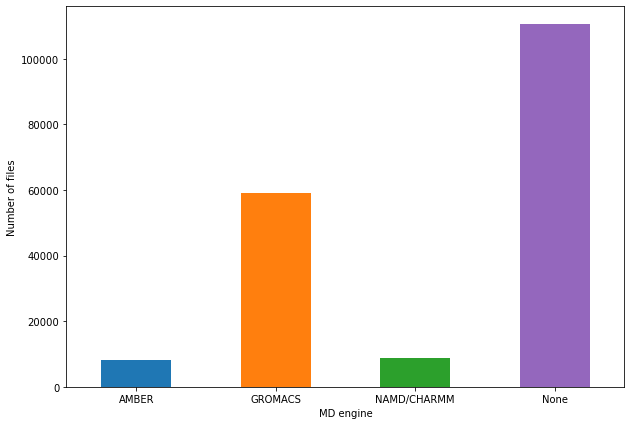

In [18]:
plt.rcParams.update({'font.size': 20})
(df
 .loc[:, "engine_MD"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", color=["tab:blue", "tab:orange", "tab:green", "tab:purple"], figsize=(10,7))
)
plt.xlabel("MD engine")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_MD_engine.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_MD_engine.svg", bbox_inches="tight")

#### Number of datasets per years

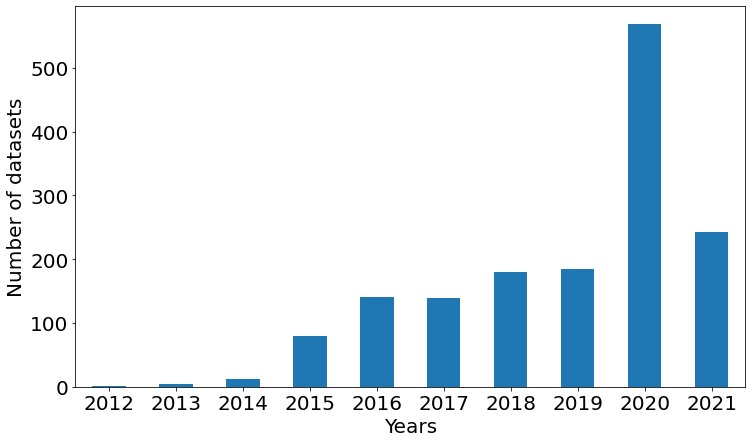

In [19]:
plt.rcParams.update({'font.size': 20})
(df
 .query("year != 2022")
 .query("year >= 2012")
 .groupby(["year"])["dataset_id"]
 .nunique()
 .plot(kind="bar", figsize=(12,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of datasets")
plt.savefig("number_of_datasets_per_years.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_datasets_per_years.svg", bbox_inches="tight")

### Number of files per years

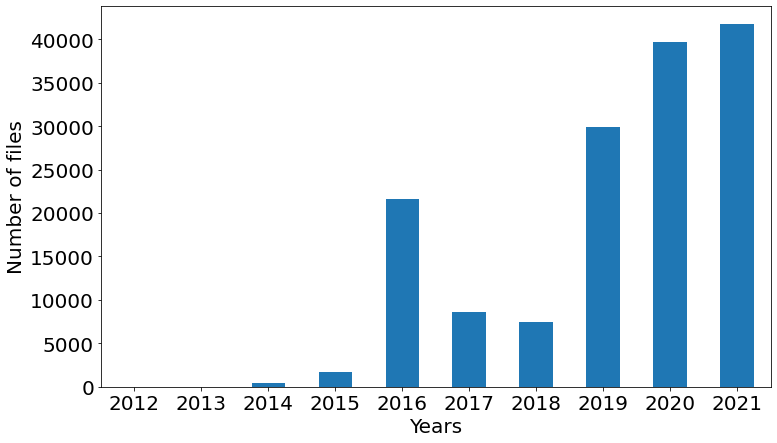

In [20]:
plt.rcParams.update({'font.size': 20})
(df
 .query("year != 2022")
 .query("year >= 2012")
 .loc[:, "year"]
 .value_counts()
 .sort_index()
 .plot(kind="bar", figsize=(12,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_years.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_years.svg", bbox_inches="tight")

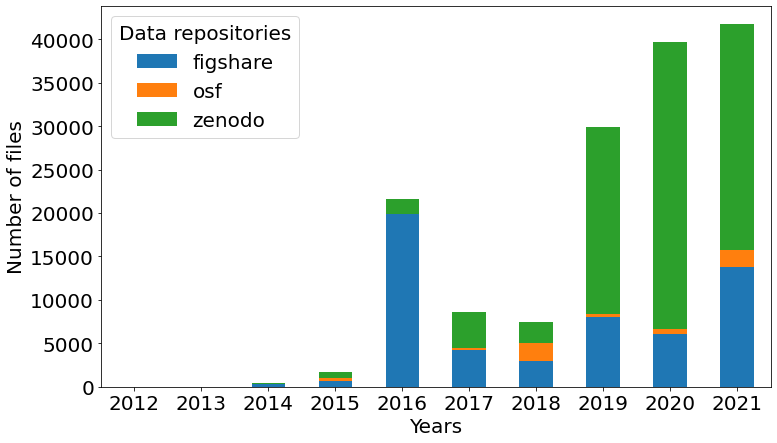

In [21]:
plt.rcParams.update({'font.size': 20})
(df
 .query("year != 2022")
 .query("year >= 2012")
 .groupby(["year", "dataset_origin"])
 .size().unstack()
 .plot(kind="bar", stacked=True, figsize=(12,7))
)
plt.xlabel("Years")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.legend(title="Data repositories")
plt.savefig("number_of_files_per_years_per_dataset_origin.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_years_per_dataset_origin.svg", bbox_inches="tight")

### Number of files per filetype

For files not associated to any MD engine.

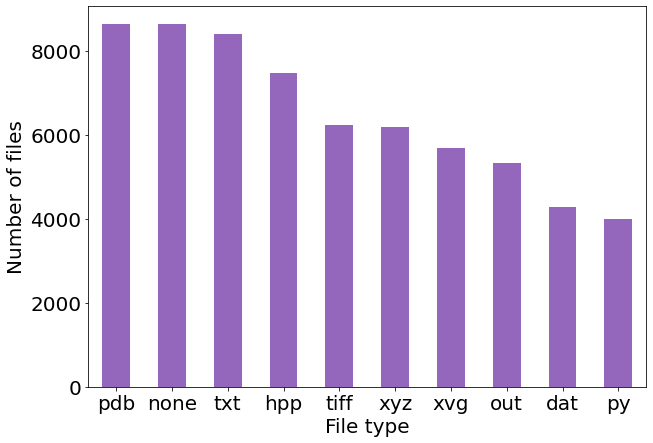

In [22]:
plt.rcParams.update({'font.size': 20})
(df
 .query("engine_MD == 'None'")
 .loc[:, "file_type"]
 .value_counts()
 .head(n=10)
 .plot(kind="bar", color="tab:purple", figsize=(10,7))
)
plt.xlabel("File type")
plt.xticks(rotation=0)
plt.ylabel("Number of files")
plt.savefig("number_of_files_per_filetype_no_MD_engine.png", dpi=300, bbox_inches="tight")
plt.savefig("number_of_files_per_filetype_no_MD_engine.svg", bbox_inches="tight")

### File size per year

- in TB
- In Zenodo, individual file size cannot go above 50 GB (see [FAQ](https://help.zenodo.org/)).

In [23]:
(df.groupby(["year"])["file_size"].sum()/10**12)

year
2009    0.000002
2012    0.000003
2013    0.000280
2014    0.002057
2015    0.217565
2016    0.183709
2017    1.221653
2018    1.816199
2019    1.914767
2020    3.166462
2021    2.567589
2022    1.244916
Name: file_size, dtype: float64